In [2]:
import numpy as np # for Array 
import pandas as pd # for DataFrames

import matplotlib.pyplot as plt # to plot
import scipy.stats as stats # to calculate spearman correlation

# Analysis MTL-Approach

In this analysis, we examine the drugs with the greatest differences in MSE and investigate how these differences correlate with the number of interactions.
- Does a high number of interactions influence the median MSE?
----

### Which drugs have the highest median MSE values?

In [3]:
# Load MSE files with baseline and naive approach
task_mses = np.loadtxt("./results/MTL/task_mses.csv", delimiter=",", skiprows=1)  # skip header
task_mses_gene = np.loadtxt("./results/MTL/naive/task_mses_gene.csv", delimiter=",", skiprows=1)  # skip header
task_mses_pathway = np.loadtxt("./results/MTL/naive/task_mses_pathway.csv", delimiter=",", skiprows=1)  # skip header
task_mses_combination = np.loadtxt("./results/MTL/naive/task_mses_combination.csv", delimiter=",", skiprows=1)  # skip header

# Get index over drug names
drug_list = pd.read_csv("./data/cl_y_test_o_k1.csv", index_col=0)
drug_list = drug_list.columns

In [5]:
# Create an DataFrame with all results
df_mse = pd.DataFrame({
    "Drug": drug_list,
    "MSE_baseline": task_mses,
    "MSE_gene": task_mses_gene,
    "MSE_pathway": task_mses_pathway,
    "MSE_combination": task_mses_combination
})

# Set "Drug"-column as index 
df_mse.set_index("Drug", inplace=True)

In [6]:
# Sort each column with Drugs with highest MSE 
for col in df_mse.columns:
    df_mse = df_mse.sort_values(by=col, ascending=False)

{'AZD5991', 'Bleomycin', 'Docetaxel', 'JQ1', 'BMS-754807', 'AZD5582', 'Mitoxantrone', 'Vincristine', 'Alisertib', 'Gemcitabine'}
Gemeinsame Top-10-Drugs über alle Ansätze: 10 gefunden


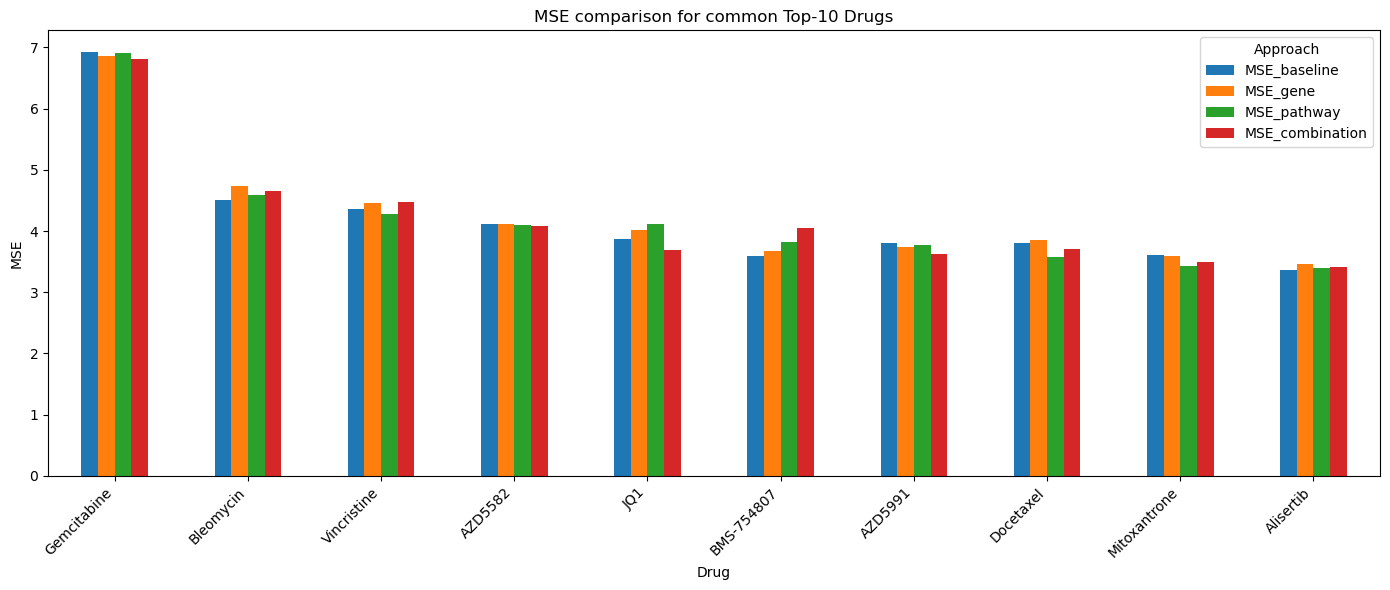

In [7]:
# Anzahl der Top-N Drugs pro Ansatz
top_n = 10

# 1. Finde die Top-N Drugs mit höchstem MSE pro Ansatz
top_drug_sets = []
for col in df_mse.columns:
    top_drugs = df_mse[col].sort_values(ascending=False).head(top_n).index
    top_drug_sets.append(set(top_drugs))

# 2. Schnittmenge aller Top-N-Drogensätze
common_top_drugs = set.intersection(*top_drug_sets)
print(common_top_drugs)
print(f"Gemeinsame Top-{top_n}-Drugs über alle Ansätze: {len(common_top_drugs)} gefunden")

# 3. Filtere den DataFrame auf diese Drugs
df_common = df_mse.loc[list(common_top_drugs)]

# 4. Sortiere nach einem festen Kriterium (z. B. Mittelwert)
df_common = df_common.loc[df_common.mean(axis=1).sort_values(ascending=False).index]

# 5. Plotten
df_common.plot(kind="bar", figsize=(14, 6))
plt.title(f"MSE comparison for common Top-{top_n} Drugs")
plt.ylabel("MSE")
plt.xlabel("Drug")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Approach")
plt.tight_layout()
plt.show()


{'Docetaxel', 'AZD5582', 'BMS-754807', 'AZD5991', 'Mitoxantrone', 'JQ1', 'Vincristine', 'Bleomycin', 'Gemcitabine', 'Alisertib'}


In [37]:
statistics = pd.read_csv('./drug_statistics.csv', index_col=0)
selected_drugs = {'Docetaxel', 'AZD5582', 'BMS-754807', 'AZD5991', 'Mitoxantrone', 'JQ1', 'Vincristine', 'Bleomycin', 'Gemcitabine', 'Alisertib'}
statistics_subset = statistics[statistics.index.isin(selected_drugs)]

In [38]:
statistics_subset

,Tested_Samples,Mean,Median,Std,Variance,Skewness,CV
Drug,,,,,,,
Docetaxel,263,-3.471703,-4.044488,2.285939,5.225517,0.662730,-0.658449
Gemcitabine,252,-0.448804,-1.001651,3.269576,10.690129,0.158158,-7.285087
Alisertib,242,1.527927,1.661884,2.369802,5.615961,-0.164276,1.550991
Mitoxantrone,238,0.301861,0.261782,2.305457,5.315134,0.144035,7.637469
AZD5991,239,3.555350,4.318087,2.862550,8.194192,-0.747668,0.805139
Vincristine,238,-1.743570,-2.284810,2.744564,7.532634,0.547991,-1.574106
AZD5582,234,2.157083,1.931485,2.194600,4.816268,-0.431702,1.017392
JQ1,16,2.564470,3.038926,1.827445,3.339554,-0.630055,0.712601
BMS-754807,15,0.945185,1.273567,1.879175,3.531300,-0.552742,1.988157


In [10]:
response_1 = pd.read_csv("./data/cl_y_test_o_k1.csv", index_col=0)
response_2 = pd.read_csv("./data/cl_y_test_o_k2.csv", index_col=0)
response_3 = pd.read_csv("./data/cl_y_test_o_k3.csv", index_col=0)
response_data = pd.concat([response_1, response_2, response_3], axis=0, ignore_index=False)

In [12]:
# Anzahl der Nicht-NaN-Werte in jeder Spalte
tozasertib_count = response_data["JQ1"].notna().sum()
bms_count = response_data["BMS-754807"].notna().sum()

print(f"Anzahl Werte in 'JQ1': {tozasertib_count}")
print(f"Anzahl Werte in 'BMS-754807': {bms_count}")


Anzahl Werte in 'JQ1': 48
Anzahl Werte in 'BMS-754807': 45


### How many interactions do the drugs with the highest MSE have?

In [15]:
dgi_matrix = pd.read_csv("./data/global_gene_interaction_matrix.csv", index_col=0).astype(np.float32)
pathway_matrix = pd.read_csv("./data/drug_pathway_binary_matrix.csv", index_col=0).astype(np.float32)

In [16]:
# Number of interactions per drug (rows)
dgi_interaction_counts = dgi_matrix.sum(axis=1)
pathway_interaction_counts = pathway_matrix.sum(axis=1)

# Add interactions as new columns to the MSE DataFrame
df_mse["DGI_interactions"] = dgi_interaction_counts
df_mse["Pathway_interactions"] = pathway_interaction_counts

In [17]:
# Plot (Number of interactions vs. mse)

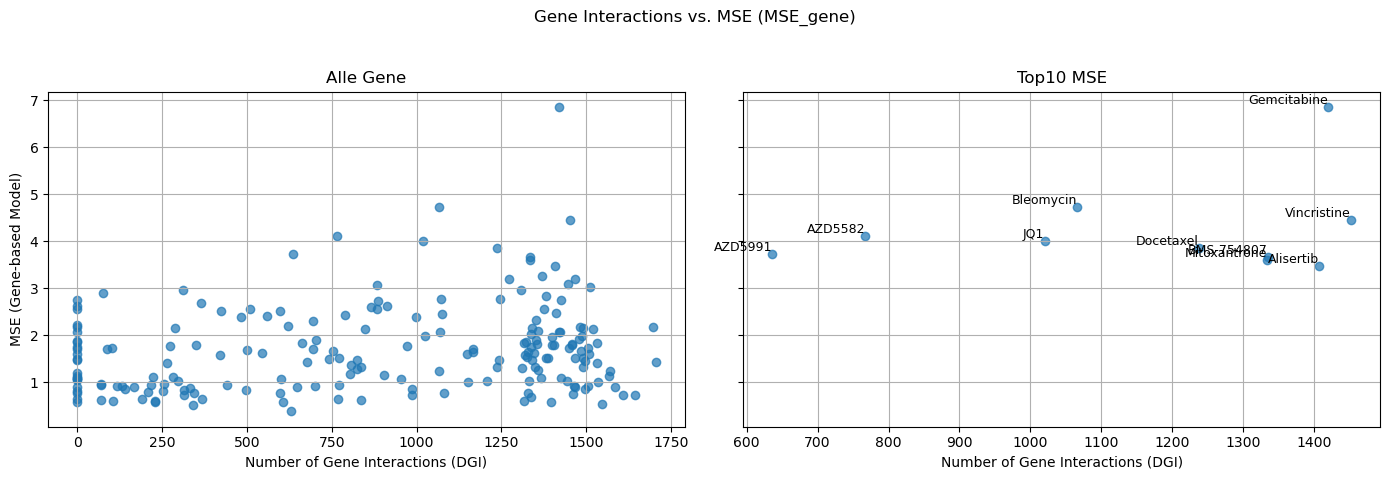

In [24]:
import matplotlib.pyplot as plt

# Liste der gewünschten Drugs
selected_drugs = {'Docetaxel', 'AZD5582', 'BMS-754807', 'AZD5991',
                  'Mitoxantrone', 'JQ1', 'Vincristine', 'Bleomycin',
                  'Gemcitabine', 'Alisertib'}

# Filtere den DataFrame auf diese Drugs
df_selected = df_mse[df_mse.index.isin(selected_drugs)]

# Erstelle nebeneinanderliegende Subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: Alle Daten
axes[0].scatter(df_mse["DGI_interactions"], df_mse["MSE_gene"], alpha=0.7)
axes[0].set_title("Alle Gene")
axes[0].set_xlabel("Number of Gene Interactions (DGI)")
axes[0].set_ylabel("MSE (Gene-based Model)")
axes[0].grid(True)

# Plot 2: Nur ausgewählte Drugs, mit Beschriftung
axes[1].scatter(df_selected["DGI_interactions"], df_selected["MSE_gene"], alpha=0.7)
for idx, row in df_selected.iterrows():
    axes[1].text(row['DGI_interactions'], row['MSE_gene'], str(idx),
                 fontsize=9, ha='right', va='bottom')
axes[1].set_title("Top10 MSE")
axes[1].set_xlabel("Number of Gene Interactions (DGI)")
axes[1].grid(True)

# Layout und Anzeige
plt.suptitle("Gene Interactions vs. MSE (MSE_gene)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### Biological ways

                     Gene_set                                               Term  Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  Combined Score                                              Genes
0  GO_Biological_Process_2023               Protein Phosphorylation (GO:0006468)  112/500  1.131571e-79      3.683264e-76            0                     0   16.026894     2913.378610  ATF2;RPS6KA3;STK11;AKT2;PRKACG;CHEK2;CHEK1;RPS...
1  GO_Biological_Process_2023  Regulation Of Cell Population Proliferation (G...  120/766  8.316388e-67      1.353492e-63            0                     0   10.416257     1584.885317  CSF1;IRS1;IRS2;FGF2;ETS1;FGF3;FGF4;CRKL;FGF5;F...
2  GO_Biological_Process_2023  Transmembrane Receptor Protein Tyrosine Kinase...   80/284  8.966862e-65      9.729046e-62            0                     0   20.116503     2966.671101  RET;GSK3B;GSK3A;FLT1;CSF1;IRS1;IRS2;FGF2;FGF3;...
3  GO_Biological_Process_2023       Regulation Of Apopto

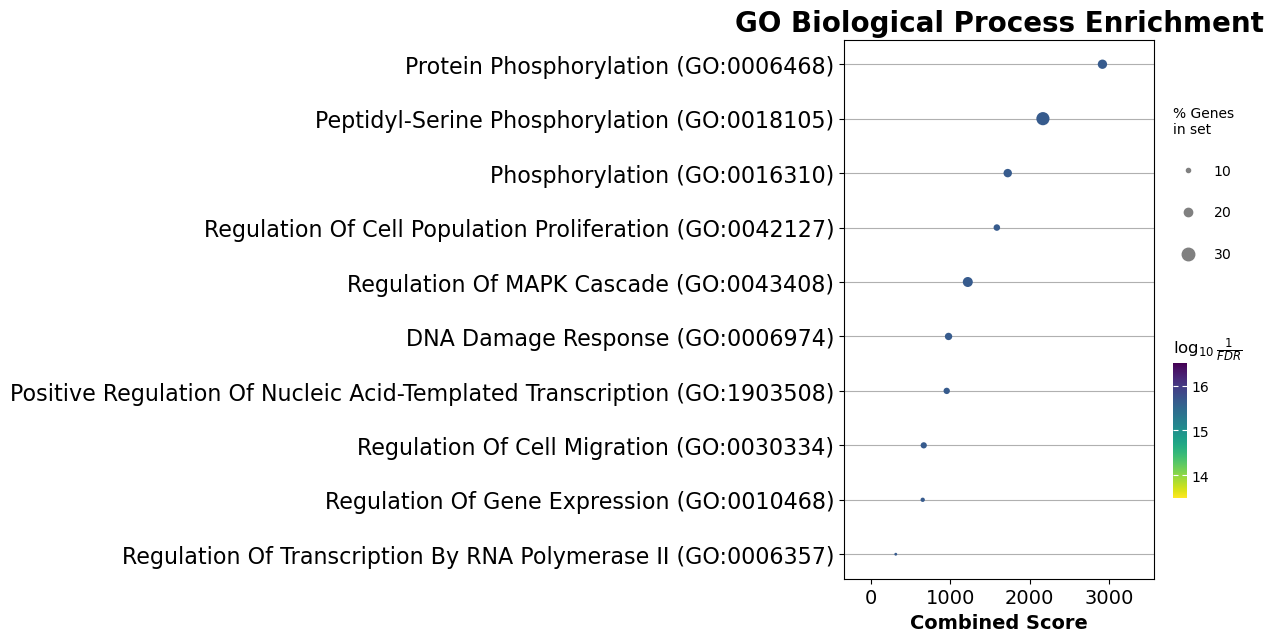

In [77]:
import gseapy as gp

# Beispiel mit deiner Genliste
gene_list = genes_with_10_hits.index.tolist()

# GO enrichment analysis
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='GO_Biological_Process_2023',
                 organism='Human',
                 outdir=None)

print(enr.results.head())

import matplotlib.pyplot as plt

# Dotplot für die Enrichment-Ergebnisse
gp.dotplot(enr.res2d, title='GO Biological Process Enrichment', figsize=(5, 7), cutoff=0.05)
plt.show()

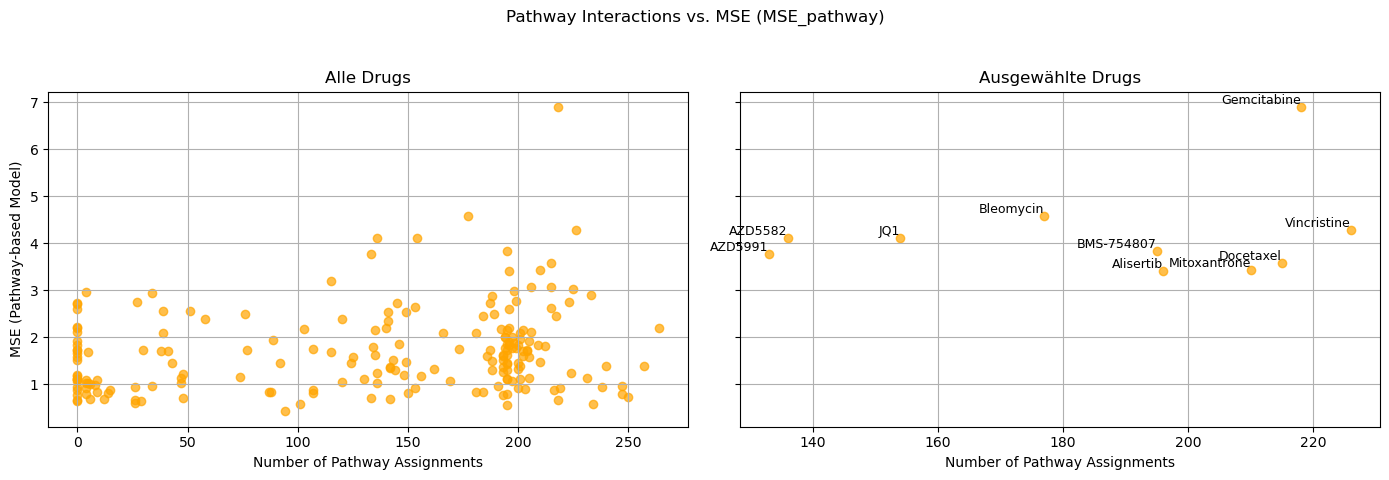

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: Alle Daten
axes[0].scatter(df_mse["Pathway_interactions"], df_mse["MSE_pathway"], alpha=0.7, color="orange")
axes[0].set_title("Alle Drugs")
axes[0].set_xlabel("Number of Pathway Assignments")
axes[0].set_ylabel("MSE (Pathway-based Model)")
axes[0].grid(True)

# Plot 2: Nur ausgewählte Drugs, mit Beschriftung
axes[1].scatter(df_selected["Pathway_interactions"], df_selected["MSE_pathway"], alpha=0.7, color="orange")
for idx, row in df_selected.iterrows():
    axes[1].text(row['Pathway_interactions'], row['MSE_pathway'], str(idx),
                 fontsize=9, ha='right', va='bottom')
axes[1].set_title("Ausgewählte Drugs")
axes[1].set_xlabel("Number of Pathway Assignments")
axes[1].grid(True)

# Layout und Anzeige
plt.suptitle("Pathway Interactions vs. MSE (MSE_pathway)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [1]:
import pandas as pd
import numpy as np

dgi_matrix = pd.read_csv("./data/global_gene_interaction_matrix.csv", index_col=0).astype(np.float32)
pathway_matrix = pd.read_csv("./data/drug_pathway_binary_matrix.csv", index_col=0).astype(np.float32)

selected_drugs = {'Docetaxel', 'AZD5582', 'BMS-754807', 'AZD5991',
                  'Mitoxantrone', 'JQ1', 'Vincristine', 'Bleomycin',
                  'Gemcitabine', 'Alisertib'}

# Filter auf ausgewählte Drugs (Zeilen)
pathway_selected = pathway_matrix.loc[pathway_matrix.index.intersection(selected_drugs)]
dgi_selected = dgi_matrix.loc[dgi_matrix.index.intersection(selected_drugs)]

In [ ]:
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import seaborn as sns

gp = GProfiler(return_dataframe=True)
gene_list = dgi_selected.columns[(dgi_selected.sum(axis=0) == 10)].tolist()

# Enrichment Analyse gegen GO, KEGG etc.
results = gp.profile(organism='hsapiens', query=gene_list)
print(results.head())


  source      native                                     name        p_value  \
0  GO:BP  GO:0035556        intracellular signal transduction  1.779633e-184   
1  GO:BP  GO:0051716            cellular response to stimulus  2.846471e-157   
2  GO:BP  GO:0048522  positive regulation of cellular process  2.400813e-147   
3  GO:BP  GO:0016310                          phosphorylation  3.842253e-143   
4  GO:BP  GO:0048583       regulation of response to stimulus  4.691254e-142   

   significant                                        description  term_size  \
0         True  "The process in which a signal is passed on to...       2965   
1         True  "Any process that results in a change in state...       7376   
2         True  "Any process that activates or increases the f...       5920   
3         True  "The process of introducing a phosphate group ...       1320   
4         True  "Any process that modulates the frequency, rat...       3993   

   query_size  intersection_size  effe

/tmp/ipykernel_3289346/798502561.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


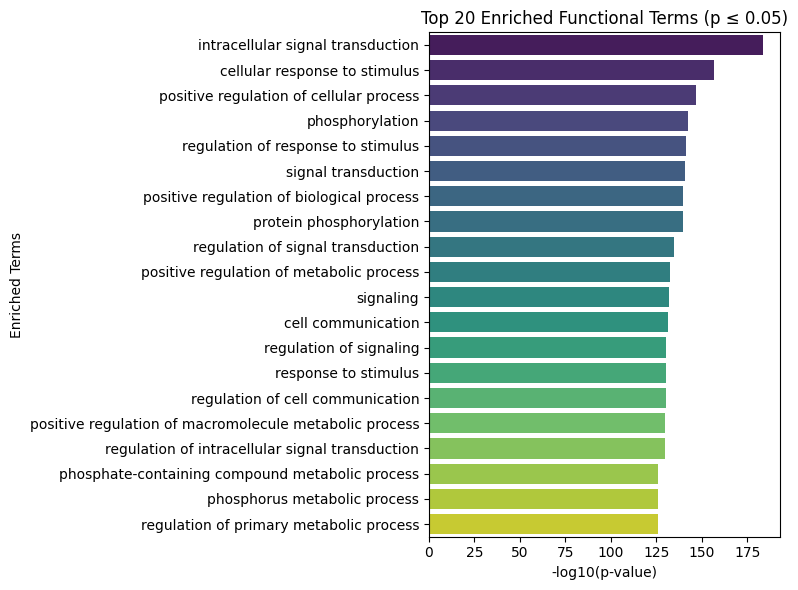

In [20]:
sig_results = results[results['p_value'] <= 0.05]

# Sortiere nach p-Wert (aufsteigend)
sig_results = sig_results.sort_values('p_value')

# Nimm z.B. die Top 20 Terms
top_terms = sig_results.head(20)

# Plot: Barplot mit -log10(p-value) für bessere Sichtbarkeit
plt.figure(figsize=(8,6))
sns.barplot(
    x=-np.log10(top_terms['p_value']),
    y=top_terms['name'],
    palette='viridis'
)
plt.xlabel('-log10(p-value)')
plt.ylabel('Enriched Terms')
plt.title('Top 20 Enriched Functional Terms (p ≤ 0.05)')
plt.tight_layout()
plt.show()


- Signaltransduktion , Proteinphosphorylierung  und Metabolismus von Phosphat-haltigen Verbindungen 

  source      native                    name        p_value  significant  \
0   KEGG  KEGG:05200      Pathways in cancer  3.472364e-123         True   
1   KEGG  KEGG:04010  MAPK signaling pathway  2.145856e-110         True   
2     WP   WP:WP5434         Cancer pathways  4.694560e-104         True   
3     WP    WP:WP382          MAPK signaling  4.929804e-100         True   
4     WP   WP:WP5087    Pleural mesothelioma   2.947606e-72         True   

              description  term_size  query_size  intersection_size  \
0      Pathways in cancer        527         434                192   
1  MAPK signaling pathway        301         434                145   
2         Cancer pathways        505         448                174   
3          MAPK signaling        245         448                127   
4    Pleural mesothelioma        435         448                136   

   effective_domain_size  precision    recall    query       parents  
0                   8484   0.442396  0.364326

/tmp/ipykernel_3289346/773630462.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='p_value', y='name', data=top_pathways, palette='viridis')


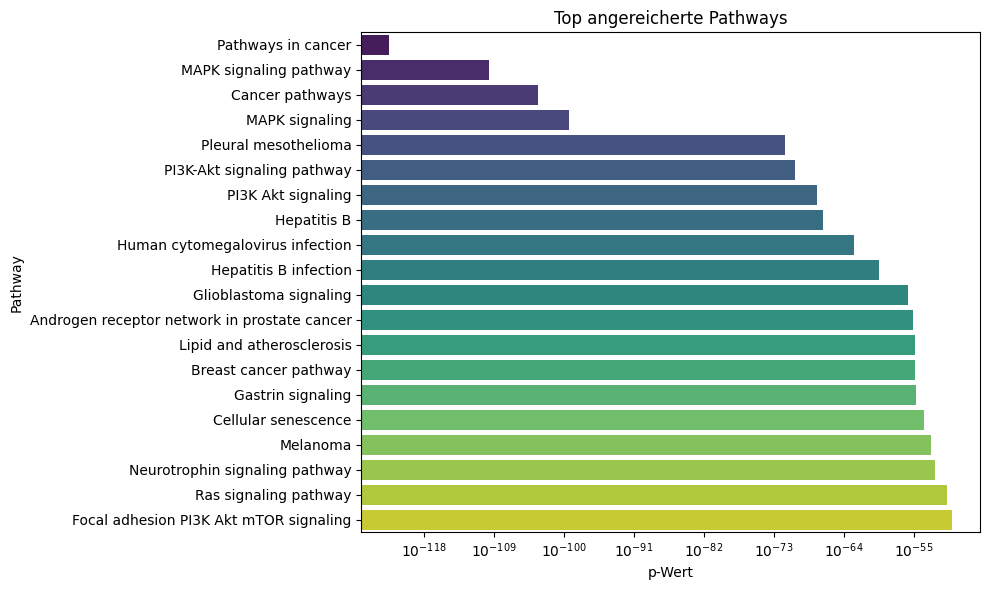

In [23]:
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import seaborn as sns

# Initialisiere GProfiler
gp = GProfiler(return_dataframe=True)

# Deine Genliste (wie in deinem Code)
gene_list = dgi_selected.columns[(dgi_selected.sum(axis=0) == 10)].tolist()

# Führe Profiling mit ausgewählten Namespace/Quellen durch
results = gp.profile(
    organism='hsapiens',
    query=gene_list,
    sources=['KEGG', 'REACTOME', 'WP']  # WP = WikiPathways
)

print(results.head())

# Filtere nur signifikante Ergebnisse
significant_results = results[results['p_value'] < 0.05]

# Sortiere nach p-Wert
top_pathways = significant_results.sort_values('p_value').head(20)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='p_value', y='name', data=top_pathways, palette='viridis')
plt.title('Top angereicherte Pathways')
plt.xlabel('p-Wert')
plt.ylabel('Pathway')
plt.xscale('log')
plt.tight_layout()
plt.show()

In [13]:
# Filter auf ausgewählte Drugs (Zeilen)
pathway_selected = pathway_matrix.loc[pathway_matrix.index.intersection(selected_drugs)]
dgi_selected = dgi_matrix.loc[dgi_matrix.index.intersection(selected_drugs)]

# Summiere über alle Spalten (Gene), sortiere nach Häufigkeit
gene_freq = dgi_selected.sum(axis=0).sort_values(ascending=False)

# Zeige die Top 10 am häufigsten getroffenen Gene
print(gene_freq.head(10))

# Summiere über alle Spalten (Pathways), sortiere nach Häufigkeit
pathway_freq = pathway_selected.sum(axis=0).sort_values(ascending=False)

# Zeige die Top 10 am häufigsten betroffenen Pathways
print(pathway_freq.head(10))

MAPK8     10.0
IDH2      10.0
SHC1      10.0
PPP3CC    10.0
PPP3CB    10.0
SHH       10.0
SIAH1     10.0
PPP3CA    10.0
IGF1      10.0
SKP1      10.0
dtype: float32
p53 signaling pathway                                  10.0
FoxO signaling pathway                                 10.0
Growth hormone synthesis, secretion and action         10.0
PI3K-Akt signaling pathway                             10.0
GnRH signaling pathway                                 10.0
Pancreatic cancer                                      10.0
Parathyroid hormone synthesis, secretion and action    10.0
Pathogenic Escherichia coli infection                  10.0
Pathways in cancer                                     10.0
Pathways of neurodegeneration                          10.0
dtype: float32


# Analysis DA-Approach

In [6]:
# Load each DataFrame with baseline and naive approach
preds_AUC_gene = pd.read_csv('./results/DA/preds_AUC_naiv_gene_level.csv', index_col=0)
preds_AUC_baseline = pd.read_csv('./results/DA/preds_AUC.csv', index_col=0)

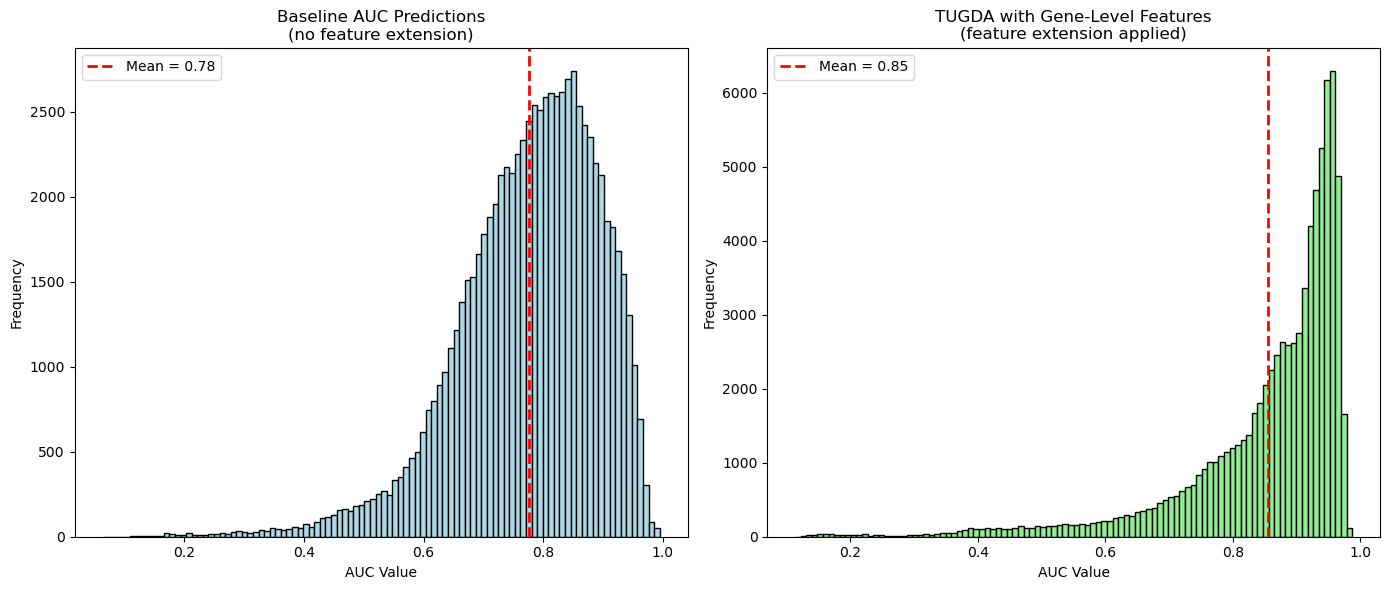

In [7]:
# drug sensitivity score AUC
# Je kleiner der AUC-Wert, desto empfindlicher ist das Modell gegenüber dem Medikament (weil weniger Dosis nötig ist, um Effekt zu erzielen)
# Ein hoher AUC-Wert bedeutet Resistenz bzw. geringere Wirkung des Medikaments.

import matplotlib.pyplot as plt
import numpy as np

# Wandle in 1D Arrays um
gene_values = preds_AUC_gene.values.flatten()
baseline_values = preds_AUC_baseline.values.flatten()

# Plot mit zwei Subplots (nebeneinander)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linkes Histogramm - Baseline
axes[0].hist(baseline_values, bins=100, color='lightblue', edgecolor='black')
axes[0].axvline(x=np.mean(baseline_values), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {np.mean(baseline_values):.2f}')
axes[0].set_xlabel('AUC Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Baseline AUC Predictions\n(no feature extension)')
axes[0].legend()

# Rechtes Histogramm - Gene-Level Extension
axes[1].hist(gene_values, bins=100, color='lightgreen', edgecolor='black')
axes[1].axvline(x=np.mean(gene_values), color='red', linestyle='--', linewidth=2,
                label=f'Mean = {np.mean(gene_values):.2f}')
axes[1].set_xlabel('AUC Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('TUGDA with Gene-Level Features\n(feature extension applied)')
axes[1].legend()

# Layout optimieren und anzeigen
plt.tight_layout()
plt.show()


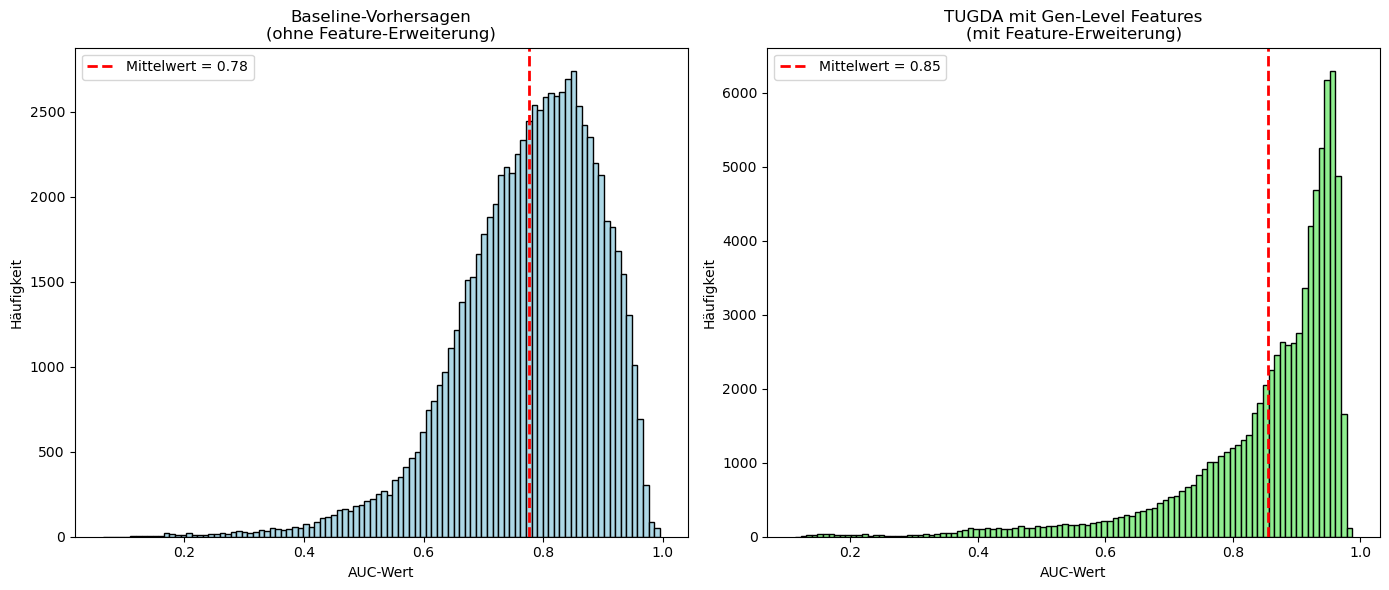

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Wandle in 1D Arrays um
gene_values = preds_AUC_gene.values.flatten()
baseline_values = preds_AUC_baseline.values.flatten()

# Plot mit zwei Subplots (nebeneinander)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Linkes Histogramm - Baseline
axes[0].hist(baseline_values, bins=100, color='lightblue', edgecolor='black')
axes[0].axvline(x=np.mean(baseline_values), color='red', linestyle='--', linewidth=2,
                label=f'Mittelwert = {np.mean(baseline_values):.2f}')
axes[0].set_xlabel('AUC-Wert')
axes[0].set_ylabel('Häufigkeit')
axes[0].set_title('Baseline-Vorhersagen\n(ohne Feature-Erweiterung)')
axes[0].legend()

# Rechtes Histogramm - Gene-Level Extension
axes[1].hist(gene_values, bins=100, color='lightgreen', edgecolor='black')
axes[1].axvline(x=np.mean(gene_values), color='red', linestyle='--', linewidth=2,
                label=f'Mittelwert = {np.mean(gene_values):.2f}')
axes[1].set_xlabel('AUC-Wert')
axes[1].set_ylabel('Häufigkeit')
axes[1].set_title('TUGDA mit Gen-Level Features\n(mit Feature-Erweiterung)')
axes[1].legend()

# Layout optimieren und anzeigen
plt.tight_layout()
plt.show()

Korrelation
- df_expression = 399 Zeilen mit 1764 Genen
- df_response = 399 Zeilen mit 200 Drugs
 
⚠️ Wichtige Einschränkungen: 

Trotzdem gibt es Dinge, die du beachten solltest: 
Nur lineare Zusammenhänge
	
Korrelation erfasst nur lineare Beziehungen. Nicht-lineare Effekte bleiben unentdeckt.
Keine Wechselwirkungen zwischen Genen
	
Es wird immer nur ein Gen isoliert betrachtet – aber in der Realität wirken Gene oft zusammen.
Batch-Effekte / Heterogenität der PDX-Proben
	
Die Proben kommen von unterschiedlichen Quellen, Gewebetypen etc. Das kann die Ergebnisse beeinflussen.
Multiple Testing Problem
	
Bei Tausenden von Genen und mehreren Medikamenten: viele Korrelationen werden zufällig signifikant → Benutze FDR-Korrektur!

In [ ]:
pdx_dataset = pd.read_csv('/sybig/home/tmu/TUGDA/data/PDX_MTL_DA.csv', index_col=0)
df_fpkm_pdx = pdx_dataset.iloc[:, :1780]

genes_to_drop = [
    "BMP10", "BMP15", "CDKL3", "CSNK1A1L", "FLT3LG", "GABRA6",
    "GUCY2F", "IL18BP", "KRT73", "OPRM1", "PRKACG", "PSKH2",
    "RHO", "SPI1", "TSSK2", "WNT8A"
]

df_expression = df_fpkm_pdx.drop(columns=genes_to_drop)

df_response = pd.read_csv('/sybig/home/tmu/Schreibtisch/Results/preds_AUC.csv')
df_response = # preds_AUC, preds_AUC_gene, preds_AUC_pathway, preds_AUC_combination

df_expression.isna().any().any()  # für das Expressions-DataFrame
df_response.isna().any().any()    # für das Response-DataFrame

In [ ]:
# For each drug-gene interaction calculate the correlation between the expression of the gene with the drug-response over all PDX

corrs = []
total = len(df_response.columns) * len(df_expression.columns)

for drug in df_response.columns:
    for gene in df_expression.columns:
        mask = df_expression[gene].notna() & df_response[drug].notna()
        if mask.sum() > 10:
            corr, pval = stats.spearmanr(df_expression.loc[mask, gene], df_response.loc[mask, drug])
            corrs.append({'Drug': drug, 'Gene': gene, 'Correlation': corr, 'P-value': pval})

df_corr = pd.DataFrame(corrs)

In [ ]:
print(df_corr.head())

Um die Interpretierbarkeit des von TUGDA gelernten Merkmalsraums zu untersuchen, haben wir die Gewichte (Attributionen) jedes Gens mit der Methode Integrated Gradients (IG) berechnet

In [ ]:
# AUC value
# Korrelation von ursprünglichen AUC Daten mit vorhersagten mean über alle Patienten 

# SHAPE: optinal 